In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import collections

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72, colors = 'kelly')

from gradvi.tests import toy_priors
from gradvi.tests import toy_data
from gradvi.models import basis_matrix as gvbm
from gradvi.optimize import moving_average as gvma
from gradvi.inference import Trendfiltering
from mrashpen.utils import R_trendfilter

def saveplot(fig, fileprefix, ext = 'png', plotdir = 'plots'):
    filename = f"{plotdir}/{fileprefix}.{ext}"
    fig.savefig(filename, bbox_inches = 'tight')
    return

plotprefix = 'simple'

In [52]:
n = 512
x = np.linspace(0, 1, n)
degree = 0
H = gvbm.trendfiltering(n, degree)
Hstd = np.sqrt(np.sum(np.square(H)) / n)

np.random.seed(106)

nknots = 10
strue = 0.1 / Hstd
knots = np.linspace(0, 1, nknots+2)[1:-1]

data = dict()

bstd = 1.0 / Hstd
btrue = np.random.normal(0, bstd, size = nknots + degree + 1)
bfix = np.cumsum(btrue)
data = toy_data.changepoint_from_bspline(x, knots, strue, degree = degree, 
                    #signal = "normal", seed = 100,
                    signal = "fixed", bfix = bfix,
                    include_intercept = True)

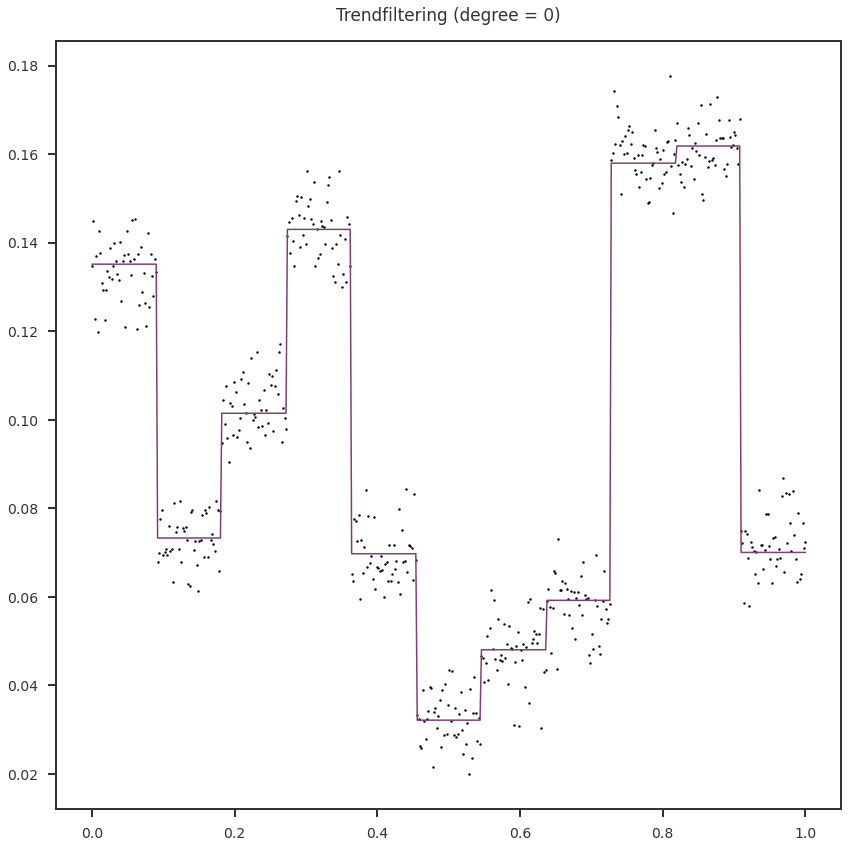

In [53]:
fig = plt.figure(figsize = (12, 12))

ax = fig.add_subplot(1, 1, 1)
ax.scatter(data.x, data.y, s = 2, color = 'black')
ax.plot(data.x, data.ytrue)
#ax.plot(data[d].x, gvma.moving_average(data[d].y))
ax.set_title(f"Trendfiltering (degree = {degree})", pad = 20)

    
fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
# utils.saveplot(fig, 'trendfiltering_simple_examples')
plt.show()

In [54]:
np.std(btrue)

0.06710128557781155

In [55]:
np.std(data.y - data.ytrue)

0.006367315659717468

In [56]:
ystd = np.std(data.y)
ymean = np.mean(data.y)
yscale = (data.y - ymean) / ystd
np.dot(yscale.T, yscale)

512.0

In [57]:
ystd

0.04466915212359579

In [58]:
bstd

0.06243905410544627

In [59]:
bstd / ystd

1.397811490414742

In [60]:
bstd * Hstd

1.0

In [61]:
bstd * Hstd / ystd

22.386813997120072

In [62]:
strue / ystd

0.1397811490414742

In [63]:
bstd_unknown = bstd

In [64]:
prior_init = toy_priors.get_ash(k = 20, sparsity = None, skbase = 2., skfactor = bstd_unknown + 1)

gv = Trendfiltering(maxiter = 10000, scale_basis = False, standardize = False)
gv.fit(data.y, degree, prior_init)
print (f"Degree {degree}. Run {gv.niter} iterations.")
print (f"Standard deviation: {np.sqrt(gv.residual_var):.3f}, expected {np.std(data.y - data.ytrue):.3f}")

Degree 0. Run 3582 iterations.
Standard deviation: 0.008, expected 0.006


In [65]:
prior2 = toy_priors.get_ash(k = 20, sparsity = None, skbase = 2., skfactor = (bstd_unknown / ystd) + 1)
gv2 = Trendfiltering(maxiter = 10000, scale_basis = False, standardize = True)
gv2.fit(data.y, degree, prior2)
print (f"Degree {degree}. Run {gv2.niter} iterations.")
expected_std = np.std(data.y - data.ytrue)# / ystd
print (f"Standard deviation: {np.sqrt(gv2.residual_var):.3f}, expected {expected_std:.3f}")

Degree 0. Run 2218 iterations.
Standard deviation: 0.031, expected 0.006


In [66]:
prior3 = toy_priors.get_ash(k = 20, sparsity = None, skbase = 2., skfactor = (bstd_unknown * Hstd) + 1)
gv3 = Trendfiltering(maxiter = 10000, scale_basis = True, standardize = False)
gv3.fit(data.y, degree, prior3)
print (f"Degree {degree}. Run {gv3.niter} iterations.")
expected_std = np.std(data.y - data.ytrue)
print (f"Standard deviation: {np.sqrt(gv3.residual_var):.3f}, expected {expected_std:.3f}")

Degree 0. Run 4359 iterations.
Standard deviation: 0.009, expected 0.006


In [67]:
prior4 = toy_priors.get_ash(k = 20, sparsity = None, skbase = 2., skfactor = (bstd_unknown * Hstd / ystd) + 1)
gv4 = Trendfiltering(maxiter = 10000, scale_basis = True, standardize = True)
gv4.fit(data.y, degree, prior4)
print (f"Degree {degree}. Run {gv4.niter} iterations.")
expected_std = np.std(data.y - data.ytrue) #/ ystd
print (f"Standard deviation: {np.sqrt(gv4.residual_var):.3f}, expected {expected_std:.3f}")

Degree 0. Run 2450 iterations.
Standard deviation: 0.032, expected 0.006


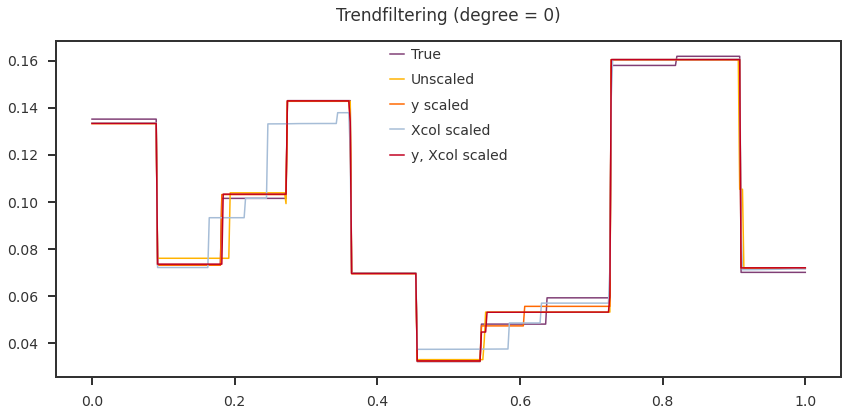

In [68]:
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(1,1,1)

ax.plot(data.x, data.ytrue, label = 'True')
ax.plot(data.x, gv.ypred, label = 'Unscaled')
ax.plot(data.x, gv2.ypred, label = 'y scaled')
ax.plot(data.x, gv3.ypred, label = 'Xcol scaled')
ax.plot(data.x, gv4.ypred, label = 'y, Xcol scaled')
ax.set_title(f"Trendfiltering (degree = {degree})", pad = 20)

ax.legend()

fig.tight_layout()
fig.subplots_adjust(wspace=0.25)
# utils.saveplot(fig, 'trendfiltering_simple_examples')
plt.show()

In [69]:
np.set_printoptions(precision = 3)
n * gv.prior.w[-1]

1.8514021110337404

In [70]:
n * gv2.prior.w[-1]

0.011371216519163929

In [71]:
n * gv3.prior.w[-1]

0.6760591464458892

In [72]:
n * gv4.prior.w[-1]

0.32442873156790364

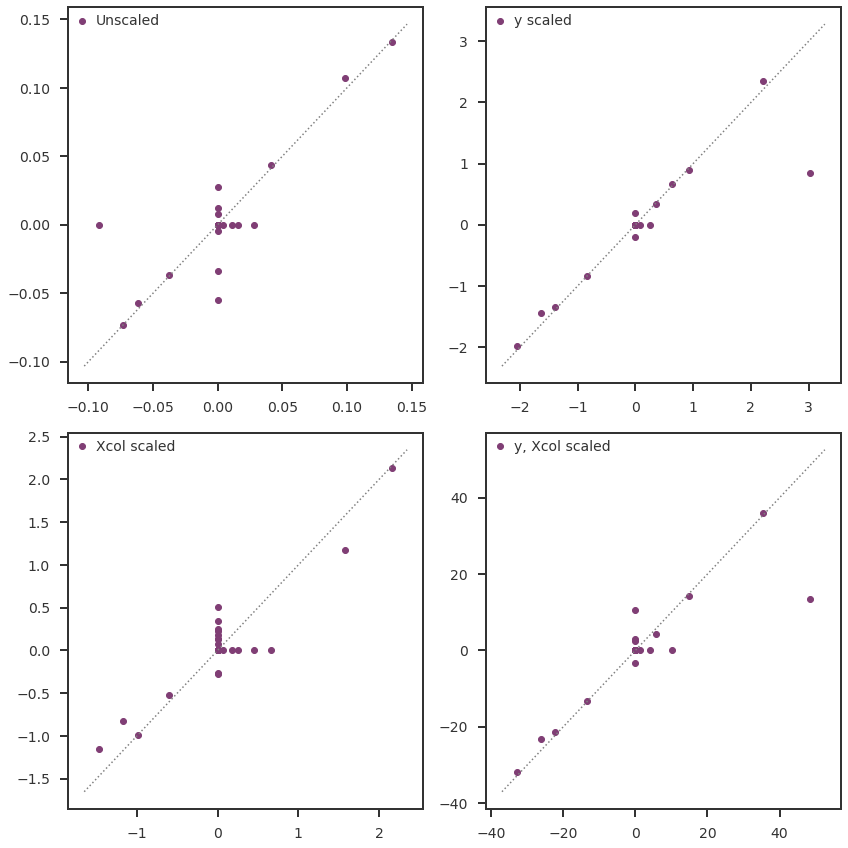

In [73]:
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(data.btrue, gv.coef, label = 'Unscaled')
ax2.scatter(data.btrue / ystd, gv2.coef, label = 'y scaled')
ax3.scatter(data.btrue * Hstd, gv3.coef, label = 'Xcol scaled')
ax4.scatter(data.btrue * Hstd / ystd, gv4.coef, label = 'y, Xcol scaled')

for ax in [ax1, ax2, ax3, ax4]:
    mpl_utils.plot_diag(ax)
    ax.legend()

fig.tight_layout()
plt.show()

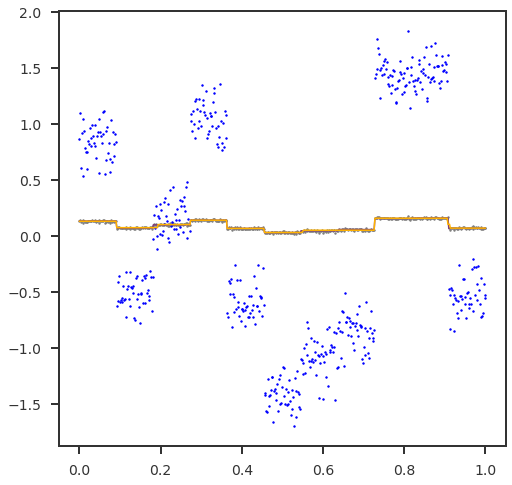

In [74]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax1.scatter(data[d].x, gv[d]._y, s = 2, color = 'gray')
ax1.scatter(data.x, data.y, s = 2, color = 'gray')
ax1.scatter(data.x, gv2._y, s = 2, color = 'blue')
ax1.plot(data.x, data.ytrue)
ax1.plot(data.x, gv.ypred, label = 'GradVI')
plt.show()

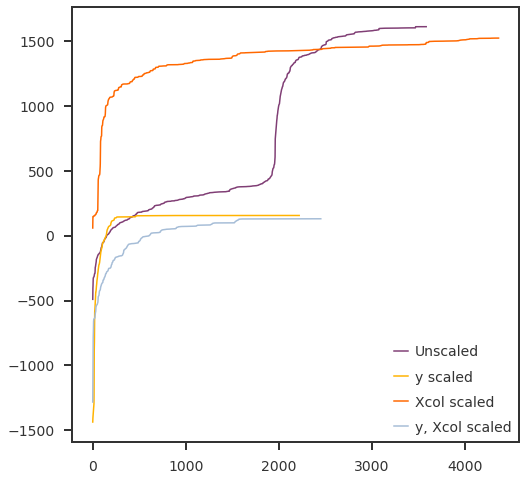

In [75]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

skip = 0
ax1.plot(np.arange(gv.niter - skip), -gv.elbo_path[skip:], label = 'Unscaled')
ax1.plot(np.arange(gv2.niter - skip), -gv2.elbo_path[skip:], label = 'y scaled')
ax1.plot(np.arange(gv3.niter - skip), -gv3.elbo_path[skip:], label = 'Xcol scaled')
ax1.plot(np.arange(gv4.niter - skip), -gv4.elbo_path[skip:], label = 'y, Xcol scaled')

ax1.legend()
plt.show()

# RMSE

In [76]:
rmse = np.sqrt(np.mean(np.square(gv.ypred - data.ytrue)))
print (f"{rmse:.5f} Unscaled inputs")
rmse = np.sqrt(np.mean(np.square(gv2.ypred - data.ytrue)))
print (f"{rmse:.5f} y scaled")
rmse = np.sqrt(np.mean(np.square(gv3.ypred - data.ytrue)))
print (f"{rmse:.5f} Xcol scaled")
rmse = np.sqrt(np.mean(np.square(gv4.ypred - data.ytrue)))
print (f"{rmse:.5f} y, Xcol scaled")

0.00526 Unscaled inputs
0.00219 y scaled
0.00742 Xcol scaled
0.00297 y, Xcol scaled
